## Test of BERT in TensorFlow - Keras

Code based on https://huggingface.co/transformers/quickstart.html

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from transformers import BertTokenizer, TFBertModel

In [4]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenizer.encode(text, add_special_tokens=False)

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

In [6]:
#tokenizer.prepare_for_model(tokenizer.encode(text, add_special_tokens=False))

In [7]:
# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
tokenized_text

['[CLS]',
 'who',
 'was',
 'jim',
 'henson',
 '?',
 '[SEP]',
 'jim',
 'henson',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

In [8]:
# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
indexed_tokens

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

# IMDB data preparation
From https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

In [9]:
import os
import re
import pandas as pd
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

In [10]:
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,"As others have noted, this should have been an...",4,0
1,"I was really looking forward to watching this,...",3,0
2,i first saw this movie at the sundance film fe...,10,1
3,"Another entry in the ""holiday horror"" category...",8,1
4,No wonder this was released straight to DVD he...,1,0


In [11]:
import numpy as np
# Create datasets (Only take up to max_seq_length words for memory)
max_seq_length = 500
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
#train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
#test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()


In [12]:
train_text[:3]

["As others have noted, this should have been an excellent Hammer-style film, and it seems to me that that's how most of the actors were instructed to play it... but the screenplay is so leaden, poorly paced, and filled with a lot of dull soliloquies (poor Timothy Dalton is saddled with most of them) that it's all too overblown and self-important. This is an uncharacteristically weak performance from Dalton, although he quietly nails the climactic scene where Dr. Rock finally realizes what he's done. The only actor who comes off really well is Patrick Stewart who is a most welcome sight. Freddie Francis may have been a great cinematographer, but he was a lousy director.",
 "I was really looking forward to watching this, being that I love Danny Dyer and I think Gillian Anderson is a gifted actress. The beginning was interesting. I liked the relationship between the two stars. It then quickly jumps to the main plot, which is they get attacked by a group of strangers and Dyer gets beaten 

In [13]:
train_label[:3]

[0, 0, 1]

In [14]:
from multiprocessing import Pool
from functools import partial
def text_to_indices(data, limit=500):
    "Convert the text to indices and pad-truncate to the maximum number of words"
    with Pool() as pool:
        return pool.map(partial(tokenizer.encode,
                                      add_special_tokens=True, max_length=limit, pad_to_max_length=True),
                         data)

In [15]:
text_to_indices(["this is sentence 1", "this is sentence 2"], limit=10)

[[101, 2023, 2003, 6251, 1015, 102, 0, 0, 0, 0],
 [101, 2023, 2003, 6251, 1016, 102, 0, 0, 0, 0]]

In [16]:
print("Obtaining indices of train set")
train_indices = text_to_indices(train_text)
print("Obtaining indices of test set")
test_indices = text_to_indices(test_text)

Obtaining indices of train set
Obtaining indices of test set


# Results with BERT

In [17]:
# Load pre-trained model (weights)
bert = TFBertModel.from_pretrained('bert-base-uncased', trainable=False)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D

In [19]:
# From https://huggingface.co/transformers/_modules/transformers/modeling_tf_bert.html#TFBertModel
#inputs = tf.constant(indexed_tokens)[None, :] # Batch  size 1
inputs = Input(shape=(500,), dtype=tf.int32)
last_hidden_states = bert(inputs)[0]  # The last hidden-state is the first element of the output tuple
average_pooling = GlobalAveragePooling1D()(last_hidden_states) # Average pooling of last hidden states as recommended
outputs = Dense(1, activation=tf.nn.sigmoid)(average_pooling)
bert_model = Model(inputs, outputs)
bert_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 500, 768), (None, 109482240 
_________________________________________________________________
global_average_pooling1d (Gl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 769
Non-trainable params: 109,482,240
_________________________________________________________________


In [20]:
bert_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [21]:
history = bert_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 545s 27ms/sample - loss: 0.6567 - acc: 0.6576 - val_loss: 0.6109 - val_acc: 0.7620
Epoch 2/10
20000/20000 [==============================] - 551s 28ms/sample - loss: 0.5952 - acc: 0.7536 - val_loss: 0.5583 - val_acc: 0.7918
Epoch 3/10
20000/20000 [==============================] - 522s 26ms/sample - loss: 0.5563 - acc: 0.7738 - val_loss: 0.5241 - val_acc: 0.7866
Epoch 4/10
20000/20000 [==============================] - 511s 26ms/sample - loss: 0.5288 - acc: 0.7887 - val_loss: 0.4993 - val_acc: 0.7958
Epoch 5/10
20000/20000 [==============================] - 512s 26ms/sample - loss: 0.5077 - acc: 0.7967 - val_loss: 0.4770 - val_acc: 0.8140
Epoch 6/10
20000/20000 [==============================] - 509s 25ms/sample - loss: 0.4938 - acc: 0.7998 - val_loss: 0.4614 - val_acc: 0.8172
Epoch 7/10
20000/20000 [==============================] - 529s 26ms/sample - loss: 0.4794 - acc: 0.8104 -

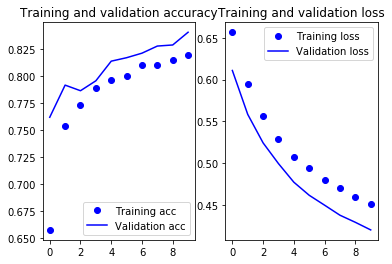

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results with Average baseline

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D

In [24]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
avg = GlobalAveragePooling1D()(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(avg)
avg_model = Model(inputs, outputs)
avg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 32)           976704    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 976,737
Trainable params: 976,737
Non-trainable params: 0
_________________________________________________________________


In [25]:
avg_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [26]:
history = avg_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 130us/sample - loss: 0.6864 - acc: 0.6194 - val_loss: 0.6746 - val_acc: 0.7562
Epoch 2/20
20000/20000 [==============================] - 2s 104us/sample - loss: 0.6550 - acc: 0.7467 - val_loss: 0.6300 - val_acc: 0.7334
Epoch 3/20
20000/20000 [==============================] - 2s 109us/sample - loss: 0.6020 - acc: 0.7872 - val_loss: 0.5729 - val_acc: 0.7954
Epoch 4/20
20000/20000 [==============================] - 2s 104us/sample - loss: 0.5444 - acc: 0.8131 - val_loss: 0.5195 - val_acc: 0.8166
Epoch 5/20
20000/20000 [==============================] - 2s 105us/sample - loss: 0.4920 - acc: 0.8363 - val_loss: 0.4744 - val_acc: 0.8362
Epoch 6/20
20000/20000 [==============================] - 2s 103us/sample - loss: 0.4467 - acc: 0.8568 - val_loss: 0.4351 - val_acc: 0.8524
Epoch 7/20
20000/20000 [==============================] - 2s 108us/sample - loss: 0.4083 - acc: 0.8702 - val_lo

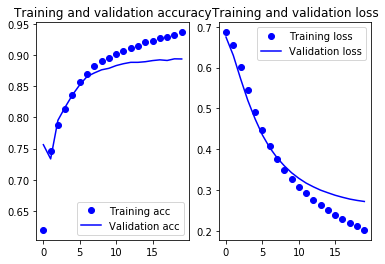

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results with LSTM baseline

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM

In [36]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
lstm = LSTM(embeddings_size, dropout=0.2)(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(lstm)
lstm_model = Model(inputs, outputs)
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 32)           976704    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 985,057
Trainable params: 985,057
Non-trainable params: 0
_________________________________________________________________


In [37]:
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [38]:
history = lstm_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 330us/sample - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6942 - val_acc: 0.5092
Epoch 2/10
20000/20000 [==============================] - 5s 274us/sample - loss: 0.6923 - acc: 0.5146 - val_loss: 0.6918 - val_acc: 0.5128
Epoch 3/10
20000/20000 [==============================] - 6s 276us/sample - loss: 0.6780 - acc: 0.5422 - val_loss: 0.6919 - val_acc: 0.5104
Epoch 4/10
20000/20000 [==============================] - 5s 273us/sample - loss: 0.6391 - acc: 0.5669 - val_loss: 0.6952 - val_acc: 0.5362
Epoch 5/10
20000/20000 [==============================] - 6s 275us/sample - loss: 0.6568 - acc: 0.5732 - val_loss: 0.7082 - val_acc: 0.5050
Epoch 6/10
20000/20000 [==============================] - 5s 274us/sample - loss: 0.6235 - acc: 0.5674 - val_loss: 0.7266 - val_acc: 0.5088
Epoch 7/10
20000/20000 [==============================] - 6s 282us/sample - loss: 0.6042 - acc: 0.5751 - val_lo

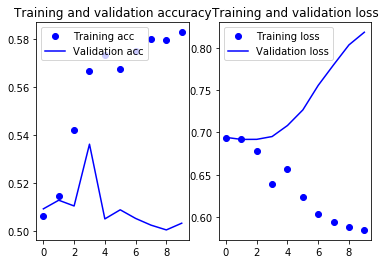

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()